In [122]:
# Predicts whether BTC price will go UP (+1) or DOWN (-1) on the next minute, using the last 5 minutes of log returns as binary features (lag bins).

In [123]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [124]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline
tf.random.set_seed(1000)

In [125]:
raw = pd.read_csv(r"C:\Users\ferul\Desktop\BTC_1min_sample.csv",
                  index_col=0, parse_dates=True).dropna()

In [126]:
raw.info()
raw.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23027 entries, 2026-01-25 00:00:00 to 2026-02-09 23:58:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    23027 non-null  float64
 1   high    23027 non-null  float64
 2   low     23027 non-null  float64
 3   close   23027 non-null  float64
 4   volume  23027 non-null  float64
dtypes: float64(5)
memory usage: 1.1 MB


,open,high,low,close,volume
timestamp,,,,,
2026-01-25 00:00:00,89225.50,89241.1,89079.50,89079.60,2.914934
2026-01-25 00:01:00,89100.01,89215.0,89079.50,89099.20,1.412217
2026-01-25 00:02:00,89099.20,89210.0,89079.50,89093.00,0.718612
2026-01-25 00:03:00,89099.19,89246.0,89079.50,89117.84,2.296964
2026-01-25 00:04:00,89117.83,89258.9,89099.19,89108.02,2.631427


In [127]:
# Keep only closing price

btc_data = raw.drop(columns=['open', 'high', 'low', 'volume'])
btc_data = btc_data.rename(columns={'close': 'BTC_closing_price'})

<Axes: xlabel='timestamp'>

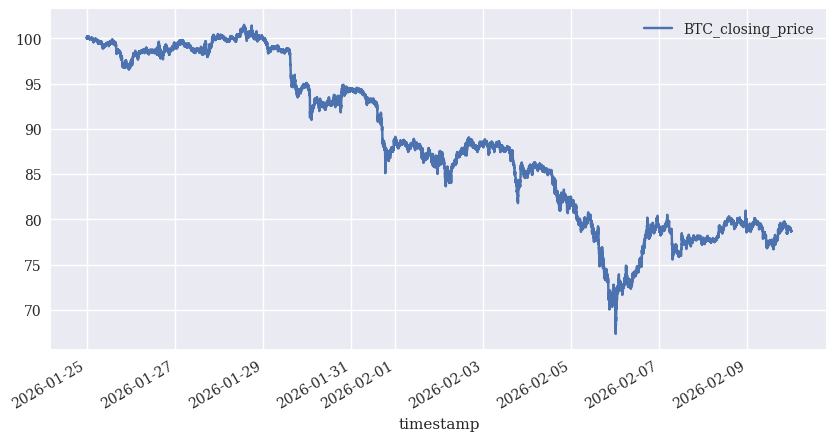

In [128]:
# Show the btc price over the time

(btc_data / btc_data.iloc[0] * 100).plot(figsize=(10,5))

array([[<Axes: title={'center': 'BTC_closing_price'}>]], dtype=object)

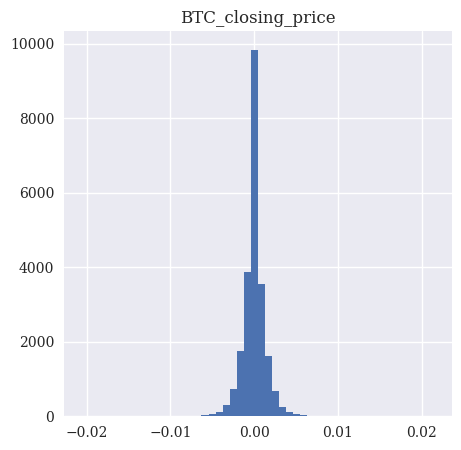

In [129]:
# transform log normal for analysis

log_returns = np.log(btc_data / btc_data.shift(1))
log_returns.head()
log_returns.hist(bins=50, figsize=(5, 5))

In [130]:
# Simple Moving Average (SMA) trading set

SMA1 = 42
SMA2 = 252

btc_data['SMA1'] = btc_data['BTC_closing_price'].rolling(SMA1).mean()
btc_data['SMA2'] = btc_data['BTC_closing_price'].rolling(SMA2).mean()
btc_data.dropna(inplace=True)

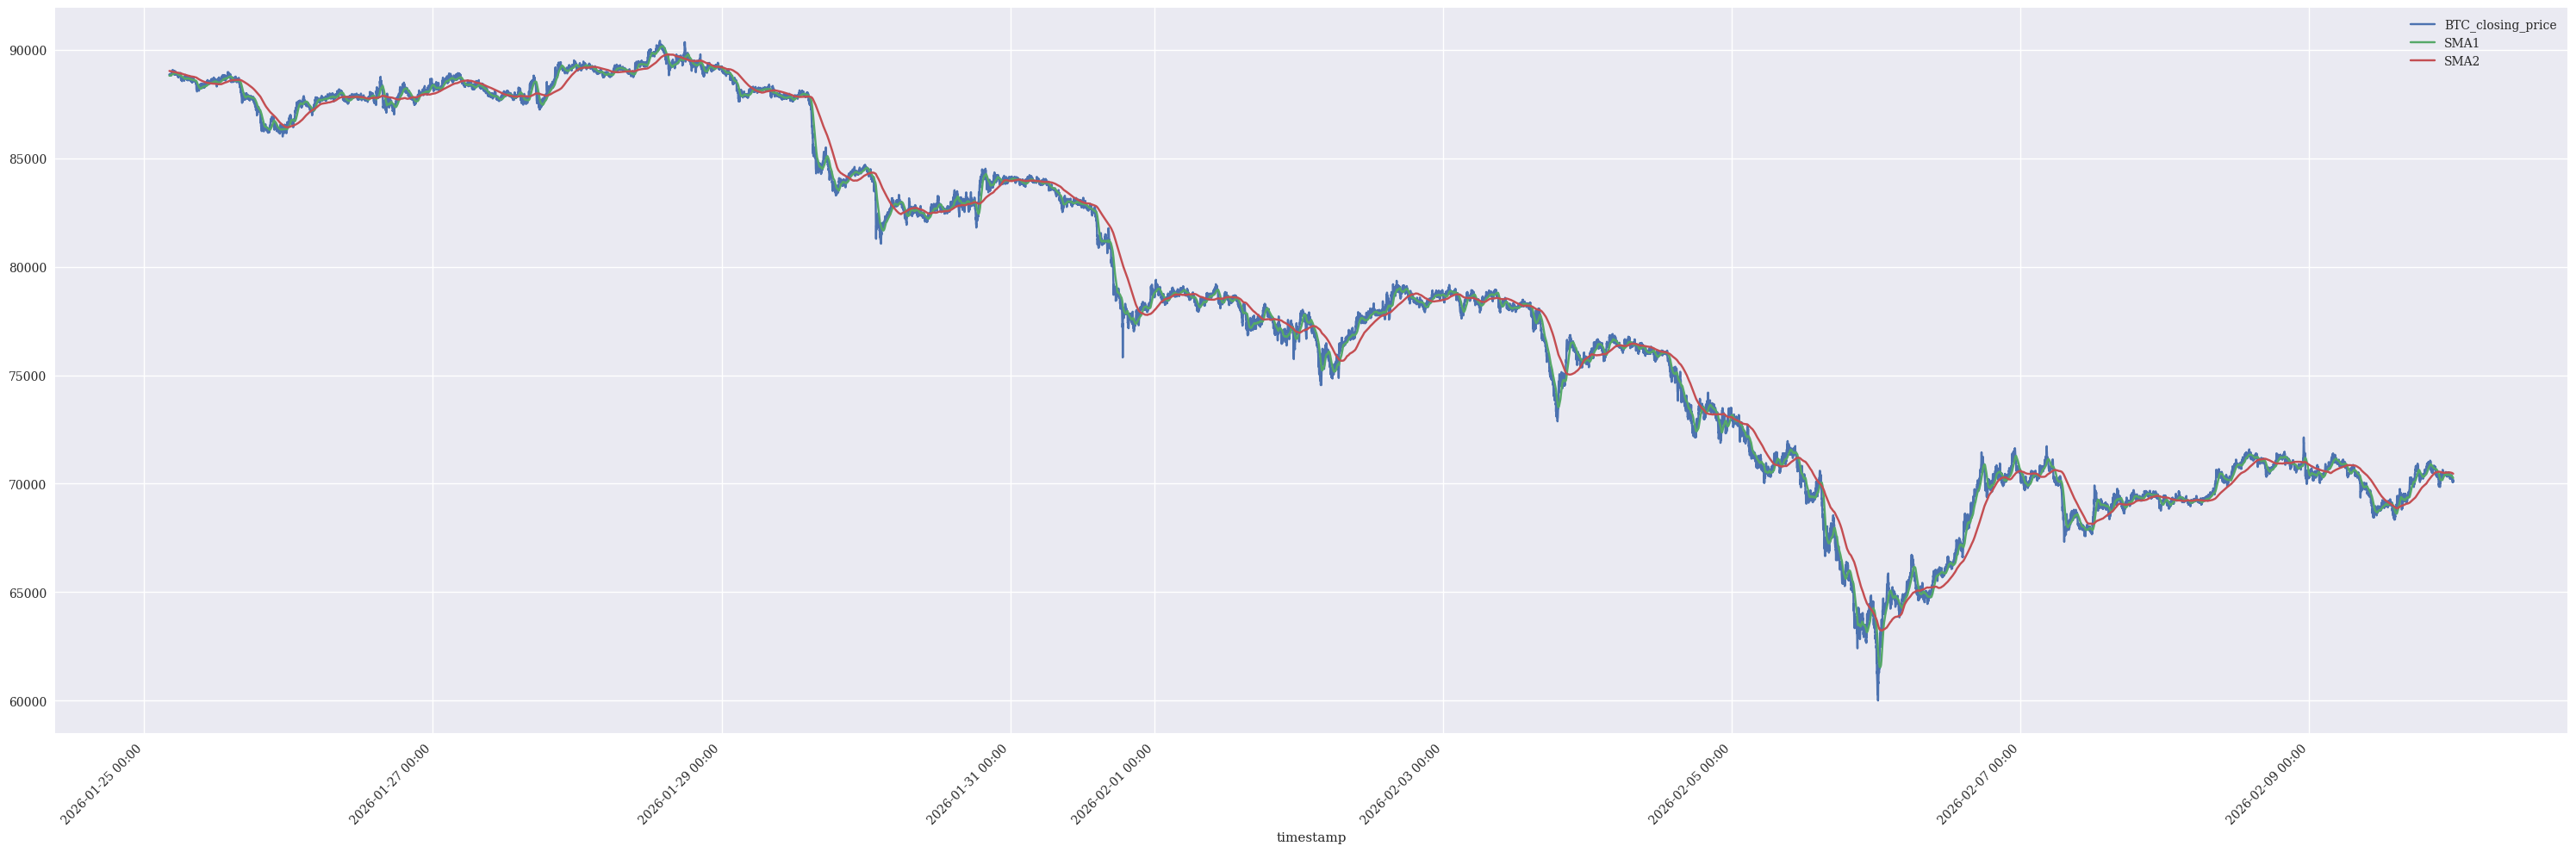

In [131]:
# Plot with integrated SMA

btc_data.plot(figsize=(30, 10))
# Format x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # automatic spacing
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # show hours:minutes

plt.xticks(rotation=45)  # rotate labels for clarity
plt.tight_layout()
plt.show()

In [132]:
# define position signal based on SMA1 and SMA2

btc_data['Position'] = np.where(btc_data['SMA1'] > btc_data['SMA2'], 1, -1)
btc_data.tail()

,BTC_closing_price,SMA1,SMA2,Position
timestamp,,,,
2026-02-09 23:54:00,70134.15,70293.527143,70473.860238,-1
2026-02-09 23:55:00,70199.00,70287.979524,70470.955476,-1
2026-02-09 23:56:00,70066.90,70278.024762,70467.685913,-1
2026-02-09 23:57:00,70109.59,70270.681667,70464.430357,-1
2026-02-09 23:58:00,70138.00,70263.729524,70461.389960,-1


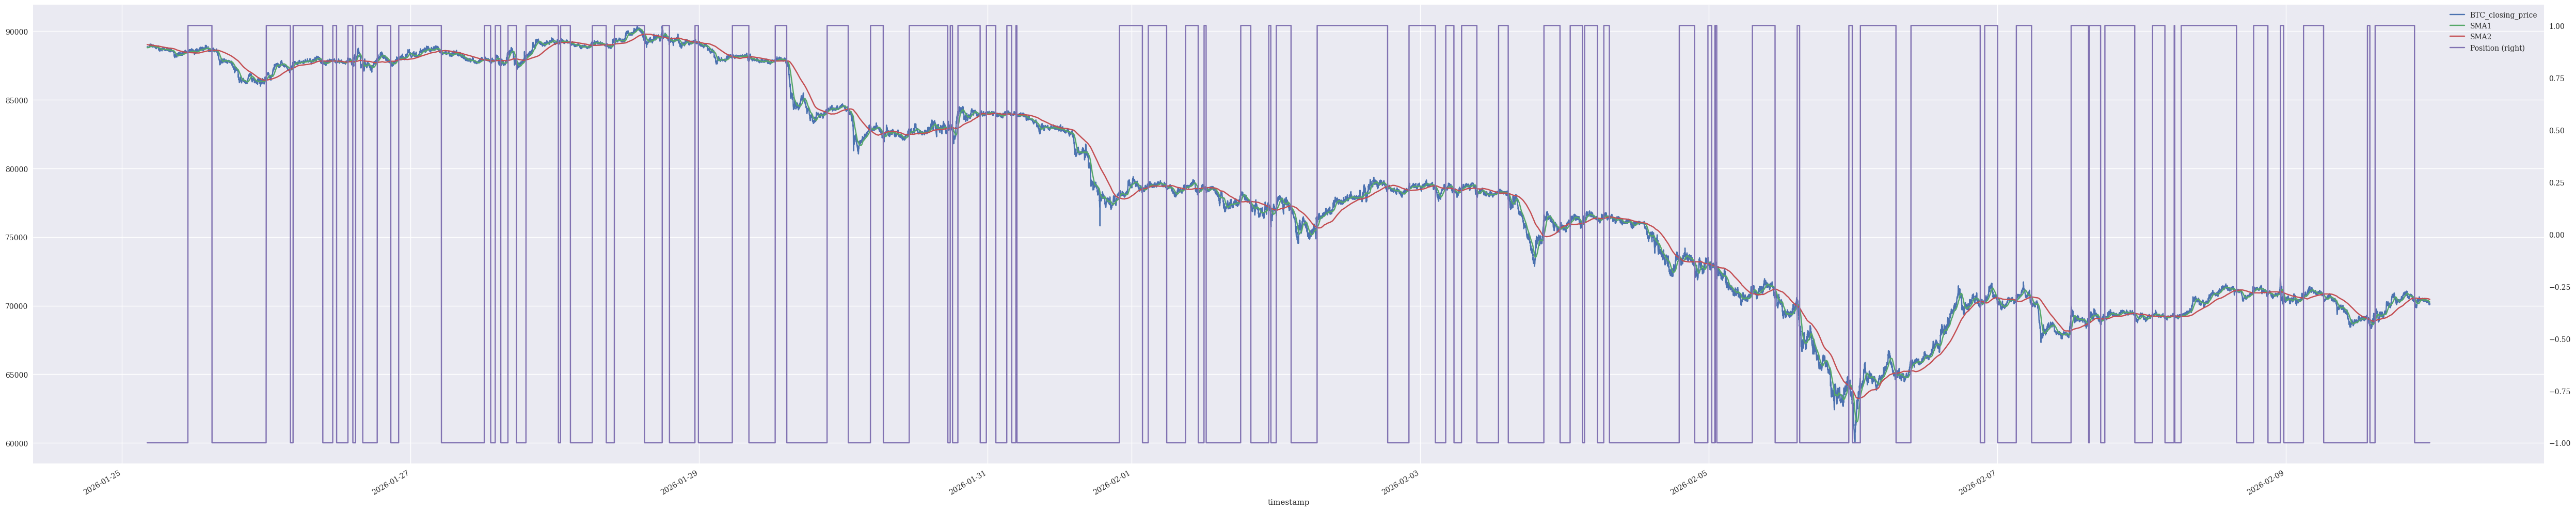

In [133]:
# plot with integrated position

ax = btc_data.plot(secondary_y='Position', figsize=(50, 10))
ax.get_legend().set_bbox_to_anchor((1, 1))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [134]:
# define returns based on log closing price, signal (direction) and strategy (position*returns)

btc_data['btc_returns'] = np.log(btc_data['BTC_closing_price'] / btc_data['BTC_closing_price'].shift(1))
btc_data['direction'] = np.sign(btc_data['btc_returns'])
btc_data['btc_strategy'] = btc_data['Position'].shift(1) * btc_data['btc_returns']
btc_data.dropna(inplace=True)
btc_data.round(4).head()

,BTC_closing_price,SMA1,SMA2,Position,btc_returns,direction,btc_strategy
timestamp,,,,,,,
2026-01-25 04:12:00,88837.69,88802.9255,89023.5346,-1,-0.0003,-1.0,0.0003
2026-01-25 04:13:00,88843.98,88804.9629,89022.5218,-1,0.0001,1.0,-0.0001
2026-01-25 04:14:00,88834.42,88807.8931,89021.4957,-1,-0.0001,-1.0,0.0001
2026-01-25 04:15:00,88861.54,88810.8276,89020.4787,-1,0.0003,1.0,-0.0003
2026-01-25 04:16:00,88854.00,88810.6848,89019.4706,-1,-0.0001,-1.0,0.0001


In [135]:
np.exp(btc_data[['btc_returns', 'btc_strategy']].sum())

btc_returns     0.789273
btc_strategy    1.021968
dtype: float64

In [136]:
btc_data[['btc_returns', 'btc_strategy']].std() * 252 ** 0.5

btc_returns     0.02141
btc_strategy    0.02141
dtype: float64

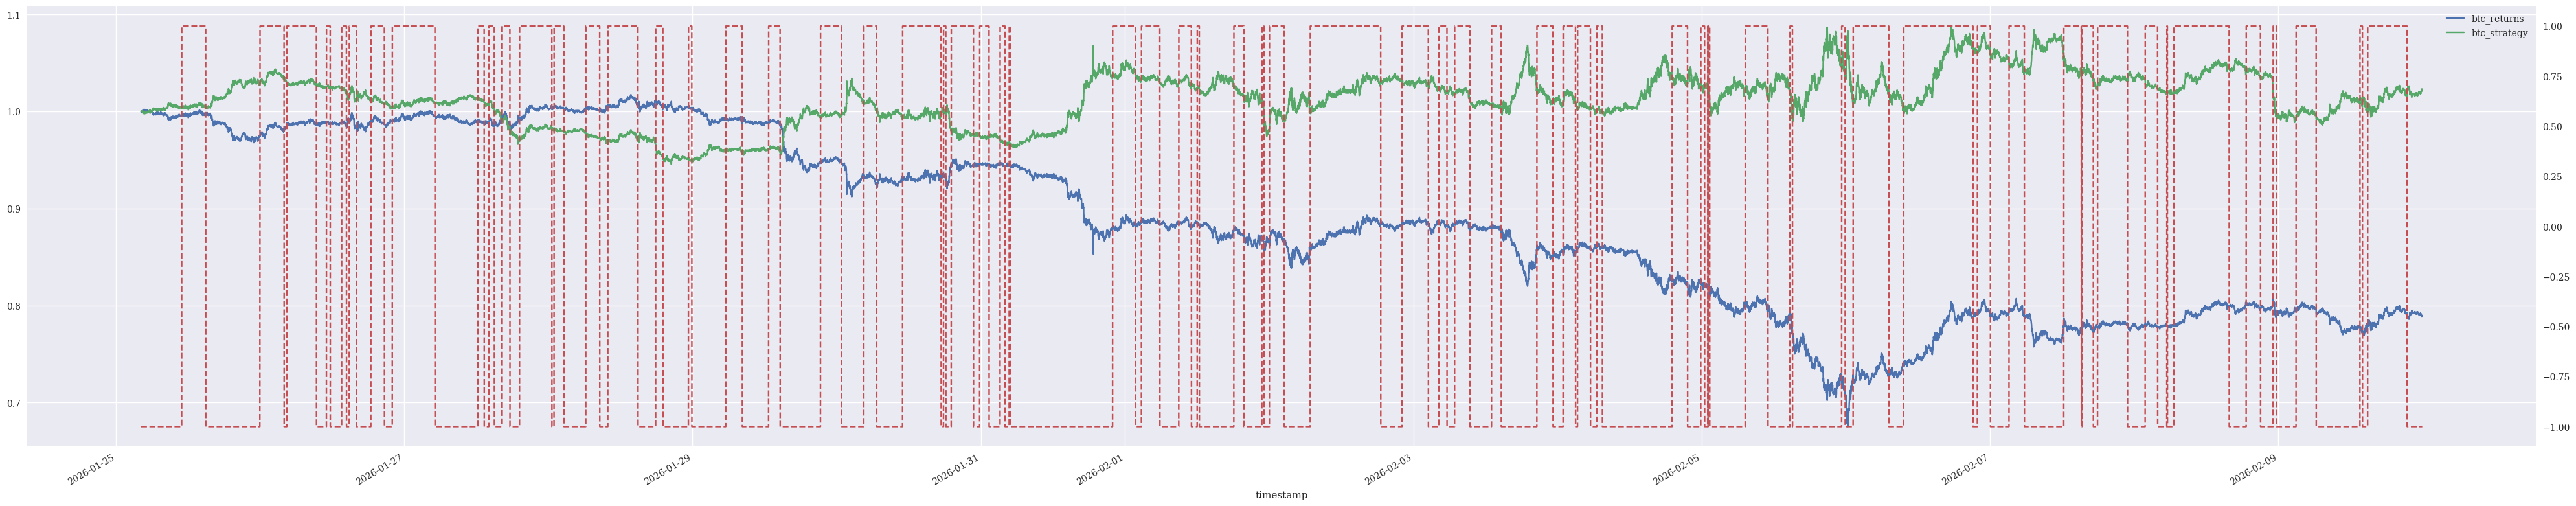

In [137]:
# plot btc returns and btc strategy

ax = btc_data[['btc_returns', 'btc_strategy']].cumsum().apply(np.exp).plot(figsize=(50,10))
btc_data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((1, 1))

In [138]:
# define lags

lags = 5
def create_lags(btc_data):
    global cols
    cols = []
    for lag in range(1, lags+1):
        col = 'lag_{}'.format(lag)
        btc_data[col] = btc_data['btc_returns'].shift(lag)
        cols.append(col)

create_lags(btc_data)
btc_data.head()

,BTC_closing_price,SMA1,SMA2,Position,btc_returns,direction,btc_strategy,lag_1,lag_2,lag_3,lag_4,lag_5
timestamp,,,,,,,,,,,,
2026-01-25 04:12:00,88837.69,88802.925476,89023.534603,-1,-0.000296,-1.0,0.000296,NaN,NaN,NaN,NaN,NaN
2026-01-25 04:13:00,88843.98,88804.962857,89022.521825,-1,0.000071,1.0,-0.000071,-0.000296,NaN,NaN,NaN,NaN
2026-01-25 04:14:00,88834.42,88807.893095,89021.495714,-1,-0.000108,-1.0,0.000108,0.000071,-0.000296,NaN,NaN,NaN
2026-01-25 04:15:00,88861.54,88810.827619,89020.478651,-1,0.000305,1.0,-0.000305,-0.000108,0.000071,-0.000296,NaN,NaN
2026-01-25 04:16:00,88854.00,88810.684762,89019.470635,-1,-0.000085,-1.0,0.000085,0.000305,-0.000108,0.000071,-0.000296,NaN


In [139]:
# define bins

def create_bins(btc_data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        btc_data[col_bin] = np.digitize(btc_data[col], bins=bins)
        cols_bin.append(col_bin)

create_bins(btc_data)
btc_data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin,direction
timestamp,,,,,,
2026-01-25 04:12:00,1,1,1,1,1,-1.0
2026-01-25 04:13:00,0,1,1,1,1,1.0
2026-01-25 04:14:00,1,0,1,1,1,-1.0
2026-01-25 04:15:00,0,1,0,1,1,1.0
2026-01-25 04:16:00,1,0,1,0,1,-1.0


In [140]:
# binned lag columns (0 or 1)

X = btc_data[cols_bin].values.astype(np.float32)

In [141]:
# direction mapped to 0 (down) or 1 (up)  for binary classification

y_raw = btc_data['direction'].values          # -1.0 or +1.0
y = np.where(y_raw == 1, 1, 0).astype(np.int32)
split = int(len(X) * 0.80)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\Train: {len(X_train):,} rows  |  Test: {len(X_test):,} rows")
print(f"   Class balance (train) — UP: {y_train.sum():,}  DOWN: {(y_train==0).sum():,}")

\Train: 18,220 rows  |  Test: 4,555 rows
   Class balance (train) — UP: 8,981  DOWN: 9,239


In [142]:
# OPTIONAL SCALING  (already 0/1 bins, but kept for potential raw-lag runs)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

In [143]:
# Input: 5 binary features (lag_1_bin … lag_5_bin)
# Hidden layers with BatchNorm + Dropout for regularisation - low dense 16, 8, 4
# Output: single sigmoid neuron → probability of price going UP


def build_model(input_dim, learning_rate=0.001):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        # Hidden layer 1
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden layer 2
        layers.Dense(8, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Hidden layer 3
        layers.Dense(4, activation='relu'),

        # Output: probability of UP move
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model(input_dim=X_train_s.shape[1])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 48 (192.00 B)

In [144]:
# training

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train_s, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5042 - loss: 0.7205 - val_accuracy: 0.5101 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5104 - loss: 0.6980 - val_accuracy: 0.5009 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5064 - loss: 0.6957 - val_accuracy: 0.5042 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5055 - loss: 0.6951 - val_accuracy: 0.5020 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5109 - loss: 0.6934 - val_accuracy: 0.4947 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 6/100
478/484 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5073 - loss: 0.6937
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5075 - loss: 0.69

In [145]:


loss, accuracy = model.evaluate(X_test_s, y_test, verbose=0)
print(f"\ Test Loss    : {loss:.4f}")
print(f" Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Predictions → class labels
y_prob = model.predict(X_test_s).flatten()
y_pred = (y_prob >= 0.5).astype(int)

print("\Classification Report:")
print(classification_report(y_test, y_pred, target_names=['DOWN (-1)', 'UP (+1)']))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

\ Test Loss    : 0.6904
 Test Accuracy: 0.5304 (53.04%)
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
\Classification Report:
              precision    recall  f1-score   support

   DOWN (-1)       0.54      0.50      0.52      2312
     UP (+1)       0.52      0.57      0.54      2243

    accuracy                           0.53      4555
   macro avg       0.53      0.53      0.53      4555
weighted avg       0.53      0.53      0.53      4555

Confusion Matrix:
[[1148 1164]
 [ 975 1268]]


In [146]:
# backtest
# Attach predictions back to the test slice of btc_data
test_slice = btc_data.iloc[split:].copy()
test_slice['ml_pred']      = np.where(y_pred == 1, 1, -1)   # +1 or -1
test_slice['ml_strategy']  = test_slice['ml_pred'].shift(1) * test_slice['btc_returns']

# Cumulative returns
perf = test_slice[['btc_returns', 'btc_strategy', 'ml_strategy']].dropna()
cumulative = perf.cumsum().apply(np.exp)

print("\Cumulative Performance (Test Period):")
print(cumulative.tail(1).round(4))

\Cumulative Performance (Test Period):
                     btc_returns  btc_strategy  ml_strategy
timestamp                                                  
2026-02-09 23:58:00       0.9929          0.95       0.9382


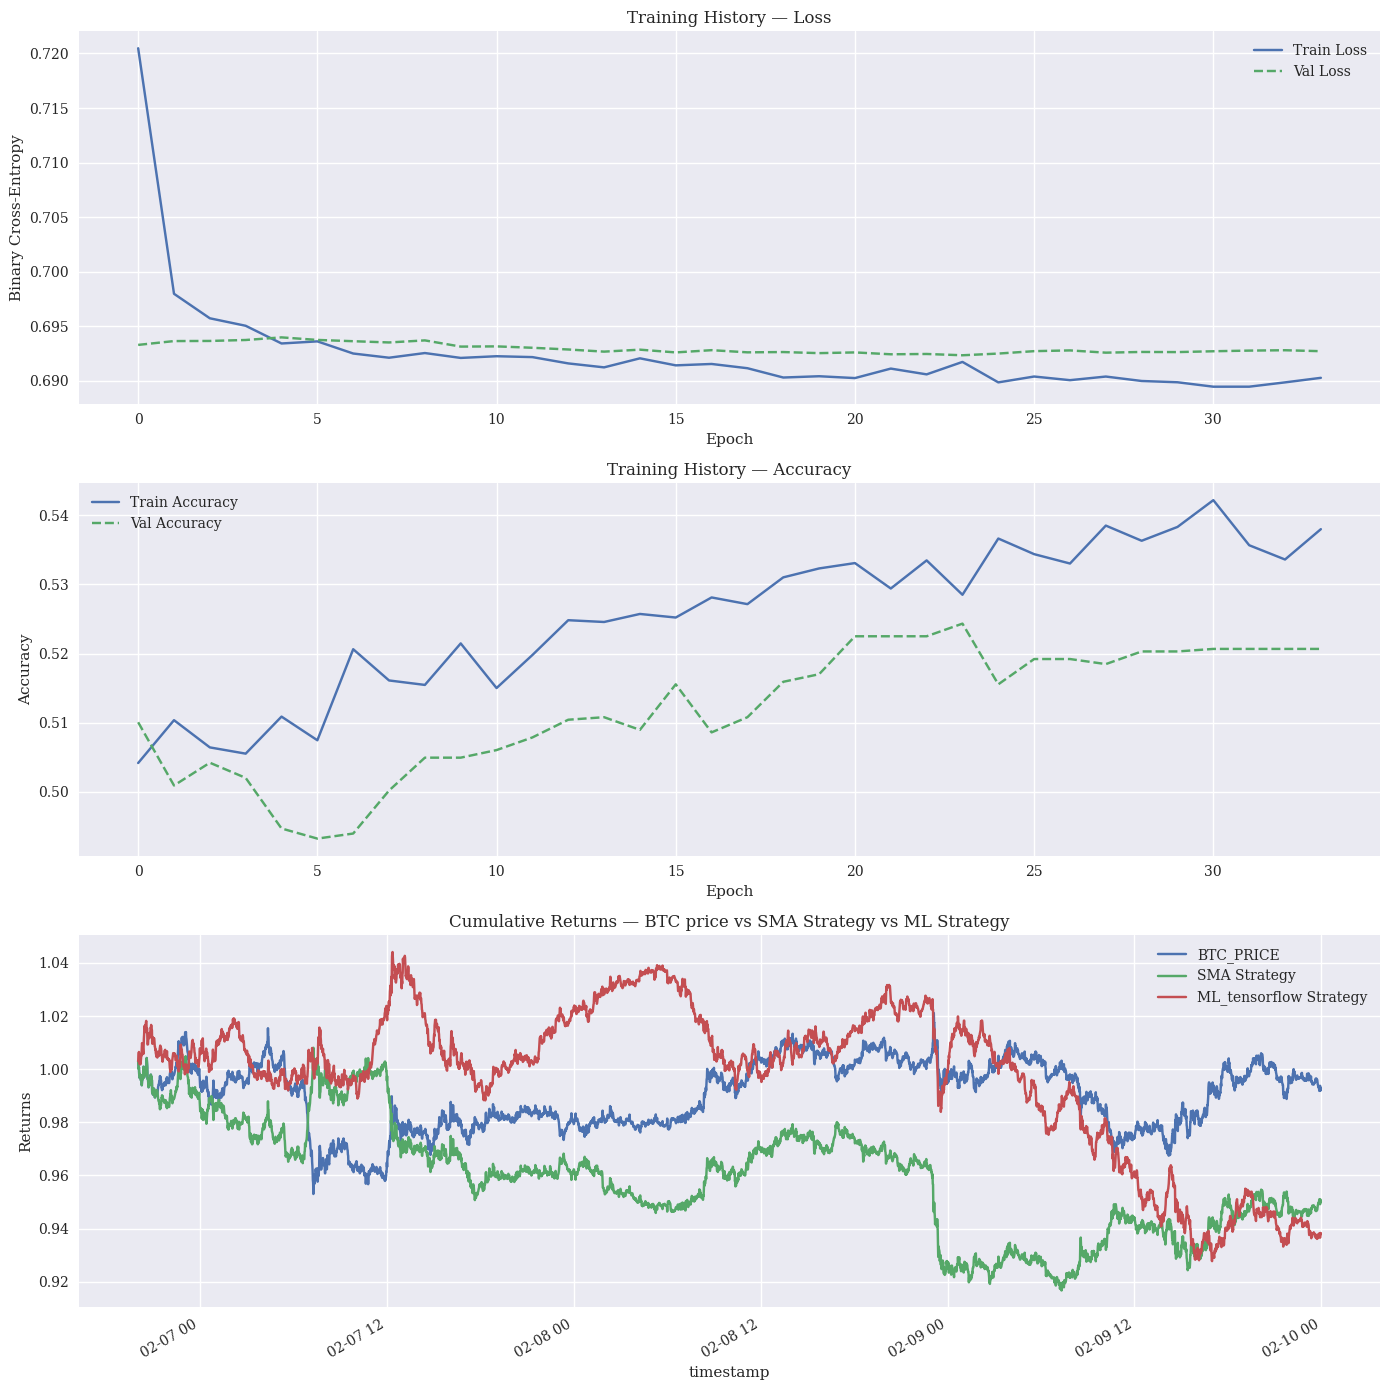

In [147]:
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# — Training history
axes[0].plot(history.history['loss'],     label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss',  linestyle='--')
axes[0].set_title('Training History — Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Binary Cross-Entropy')
axes[0].legend()

axes[1].plot(history.history['accuracy'],     label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy',  linestyle='--')
axes[1].set_title('Training History — Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# — Strategy comparison
cumulative.plot(ax=axes[2])
axes[2].set_title('Cumulative Returns — BTC price vs SMA Strategy vs ML Strategy')
axes[2].set_ylabel('Returns')
axes[2].legend(['BTC_PRICE', 'SMA Strategy', 'ML_tensorflow Strategy'])

plt.tight_layout()
plt.savefig('btc_ml_results.png', dpi=150, bbox_inches='tight')
plt.show()